In [1]:
import npaths
import numpy as np
import pickle

In [2]:
# import 2D power array
with open('power.pkl', 'rb') as f:
    power = pickle.load(f)

In [3]:
fuD = 0.819/100     # fuel pellet diameter
clD = 0.950/100     # clad diameter and fule rod outer diameter
guD = 1.224/100     # guide tube outer diameter
fuN = 264           # number of fuel rods
guN = 25            # number of guide tubes
grT = 0.45/1000     # spacer grid thickness
pit = 1.26/100      # pitch of elements in the channel

In [4]:
# calculate advanced geometery
hyD,flA,grA = npaths.geom.channel('square',pit,grT,[clD,guD],[fuN,guN])
fuA = npaths.geom.fuel([fuD],[fuN])

In [5]:
# space grid locations
grA = [0]+[grA]+[0]+[grA]+[0]+[grA]+[0]+[grA]+2*[0]+[grA]+[0]+[grA]\
               +[0]+[grA]+[0]+[grA]+[0]

In [6]:
# define adavanced geometry for each channel with the array
hyD = np.array(31*[hyD])
flA = np.array(31*[flA])
grA = np.array(31*(grA))
fuA = np.array(31*[fuA])

In [7]:
# define axial layer thickness
dz  = np.array(3*[21]+12*[20]+3*[21])/100

In [8]:
# initialize multichannel object
core = npaths.MultiChannel(fuA,dz)

In [9]:
# update multiChannel advanced geometry values
core.update("channel",(slice(None)),['hyD','flA'],(hyD,flA))
core.update("axial",(slice(None)),['q','grA'],(power,grA))

In [10]:
# solve flow properties with specific inlet conditions
mDot = 2325
pIn  = 15.6e+06
tIn  = 289.1+273.15
core.solveFlow(mDot,pIn,tIn)

In [11]:
# save flow data to pickle file
with open('core.pkl', 'wb') as f:
    pickle.dump(core, f)

In [12]:
# create define fuel rod geometry and locarions with the rod object
fuelRod = npaths.Rod("fuel",list(range(31)),['Zircaloy','UO2'],[clD,fuD],[3,20])

In [13]:
# solve fuelTemps
core.solveTemps(fuelRod)

# Post procesing

nPaThS has tools that allow for easy visulaization of both axial data and channel data

## Radial data

In [51]:
wts = np.array([1/8,
                1/2,1/2,
                1/2,1.0,1/2,
                1/2,1.0,1.0,1/2,
                1/2,1.0,1.0,1.0,1/2,
                1/2,1.0,1.0,1.0,1.0,1/2,
                1/2,1.0,1.0,1.0,1.0,1.0,
                1/2,1.0,1.0,1.0])
wts = wts[np.newaxis].T
twts = (dz*wts).flatten()
twts = twts[np.newaxis].T

In [52]:
rIn  = core.get('fuel',(0,0,slice(None)),['rIn'],'array')
rOut = core.get('fuel',(0,0,slice(None)),['rOut'],'array')
r = (rIn+rOut)/2
rIn = rIn[-1]
rOut = rOut[0]

for channelId in range(31):
    for axialId in range(18):
        tIn = core.get('fuel',(channelId,axialId,22),['tIn'],'array')
        tOut = core.get('fuel',(channelId,axialId,0),['tOut'],'array')
        t = core.get('fuel',(channelId,axialId,slice(None)),['t'],'array')
        k = core.get('fuel',(channelId,axialId,slice(None)),['k'],'array')
        if channelId == 0 and axialId ==0:
            tIns = tIn
            tOuts = tOut
            ts = t
            ks = k
        else:
            tIns = np.vstack((tIns,tIn))
            tOuts = np.vstack((tOuts,tOut))
            ts = np.vstack((ts,t))
            ks = np.vstack((ks,k))

tIn  = np.sum(tIns*twts)/np.sum(twts)
tOut = np.sum(tOuts*twts)/np.sum(twts)
t = np.sum(ts*twts,axis=0)/np.sum(twts)
t = np.concatenate((np.array([tOut]),t,np.array([tIn])))
r = np.concatenate((np.array([rOut]),r,np.array([rIn])))
k = np.sum(ks*twts,axis=0)/np.sum(twts)

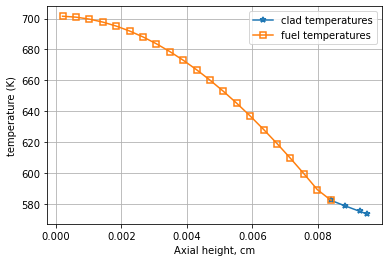

In [53]:
import matplotlib.pyplot as plt
plt.plot(r[0:4], t[0:4], marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'clad temperatures')
plt.plot(r[3:-1],t[3:-1],marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'fuel temperatures')
plt.xlabel('Axial height, cm')
plt.ylabel('temperature (K)')
plt.grid(), plt.legend()
plt.savefig("./figures/rad_temp")

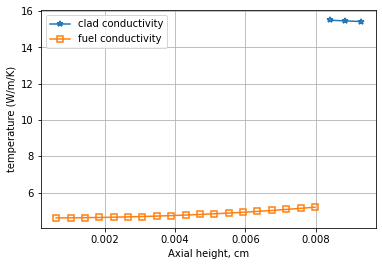

In [54]:
r = r[1:-1]
import matplotlib.pyplot as plt
plt.plot(r[0:3], k[0:3], marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'clad conductivity')
plt.plot(r[3:-1],k[3:-1],marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'fuel conductivity')
plt.xlabel('Axial height, cm')
plt.ylabel('temperature (W/m/K)')
plt.grid(), plt.legend()
plt.savefig("./figures/rad_cond")

## Axial data

Users have the option to plot axial data vs height by specifying a zMap.

In [55]:
# zMap indicates the height (in cm) of the midpoint of each axial layer in the core
zMap = np.zeros(18)
for axialId in range(18):
    if axialId == 0:
        zBot = 0
    else:
        zBot = zTop
    zTop = np.sum(dz[:axialId])
    
    zMap[axialId] = (zTop+zBot)/2*100

### Channel temperatures

In [56]:
### rod temperatures
for channelId in range(31):
    tCool = core.get('fuel',(channelId,slice(None),0),['tOut'],'array')
    tClIn = core.get('fuel',(channelId,slice(None),2),['tIn'],'array')
    tMax  = core.get('fuel',(channelId,slice(None),22),['tIn'],'array')
    if channelId == 0:
        tCools = tCool
        tClIns = tClIn
        tMaxs  = tMax
    else:
        tCools = np.vstack((tCools,tCool))
        tClIns = np.vstack((tClIns,tClIn))
        tMaxs  = np.vstack((tMaxs,tMax))

In [57]:
channelMax = np.where(tMaxs==tMaxs.max())[0][0]
tCoolMax = tCools[channelMax]
tClInMax = tClIns[channelMax]
tMaxMax  =  tMaxs[channelMax]
tCoolAvg = np.sum(tCools*wts,axis=0)/np.sum(wts)
tClInAvg = np.sum(tClIns*wts,axis=0)/np.sum(wts)
tMaxAvg  = np.sum(tMaxs*wts,axis=0)/np.sum(wts)

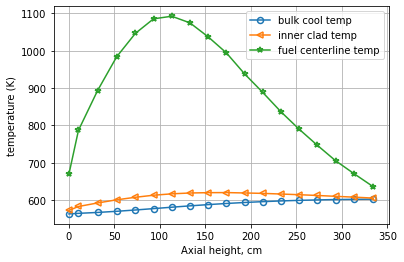

In [58]:
import matplotlib.pyplot as plt
plt.plot(zMap, tCoolMax, marker = 'o', fillstyle='none',markeredgewidth=1.5, label = 'bulk cool temp')
plt.plot(zMap, tClInMax, marker = '<', fillstyle='none',markeredgewidth=1.5, label = 'inner clad temp')
plt.plot(zMap, tMaxMax , marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'fuel centerline temp')
plt.xlabel('Axial height, cm')
plt.ylabel('temperature (K)')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_maxTemp")

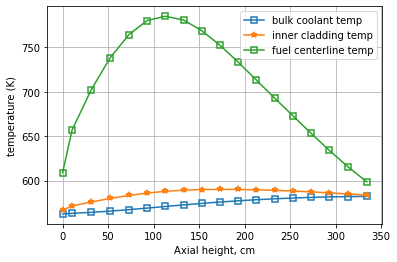

In [59]:
import matplotlib.pyplot as plt
plt.plot(zMap, tCoolAvg, marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'bulk coolant temp')
plt.plot(zMap, tClInAvg, marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'inner cladding temp')
plt.plot(zMap, tMaxAvg , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'fuel centerline temp')
plt.xlabel('Axial height, cm')
plt.ylabel('temperature (K)')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_avgTemp")

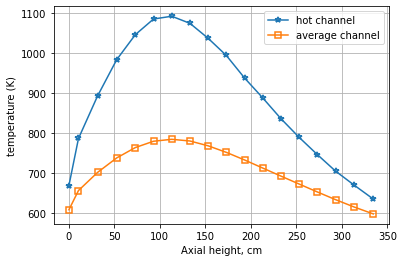

In [60]:
import matplotlib.pyplot as plt
plt.plot(zMap, tMaxMax , marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'hot channel')
plt.plot(zMap, tMaxAvg , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'average channel')
plt.xlabel('Axial height, cm')
plt.ylabel('temperature (K)')
plt.grid(), plt.legend()
plt.savefig("./figures/rax_fuelTemp")

### Bulk coolant data

In [61]:
### bulk coolant data
for channelId in range(31):
    rho,cp,vel,mu = core.get('axial',(channelId,slice(None)),['rho','cp','vel','mu'],'array')
    if channelId == 0:
        rhos = rho
        cps  = cp 
        vels = vel
        mus  = mu 
    else:
        rhos = np.vstack((rhos,rho))
        cps  = np.vstack((cps ,cp ))
        vels = np.vstack((vels,vel))
        mus  = np.vstack((mus ,mu ))

In [62]:
rhoMax = rhos[channelMax]
cpMax  =  cps[channelMax]
velMax = vels[channelMax]
muMax  =  mus[channelMax]
rhoAvg = np.sum(rhos*wts,axis=0)/np.sum(wts)
cpAvg  = np.sum( cps*wts,axis=0)/np.sum(wts)
velAvg = np.sum(vels*wts,axis=0)/np.sum(wts)
muAvg  = np.sum( mus*wts,axis=0)/np.sum(wts)

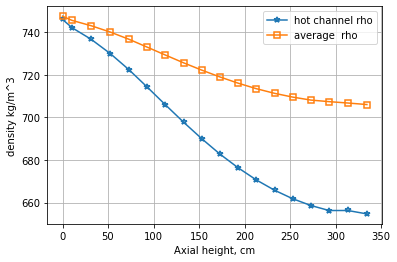

In [63]:
import matplotlib.pyplot as plt
plt.plot(zMap, rhoMax , marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'hot channel rho')
plt.plot(zMap, rhoAvg , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'average  rho')
plt.xlabel('Axial height, cm')
plt.ylabel('density kg/m^3')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_rho")

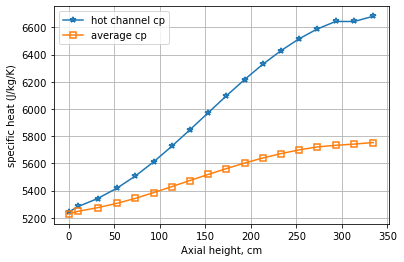

In [64]:
import matplotlib.pyplot as plt
plt.plot(zMap, cpMax , marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'hot channel cp')
plt.plot(zMap, cpAvg , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'average cp')
plt.xlabel('Axial height, cm')
plt.ylabel('specific heat (J/kg/K)')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_cp")

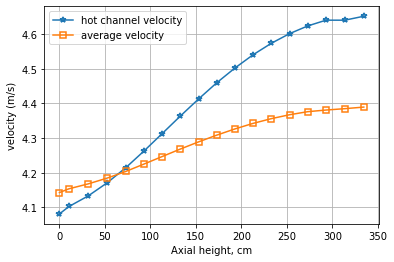

In [65]:
import matplotlib.pyplot as plt
plt.plot(zMap, velMax , marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'hot channel velocity')
plt.plot(zMap, velAvg , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'average velocity')
plt.xlabel('Axial height, cm')
plt.ylabel('velocity (m/s)')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_vel")

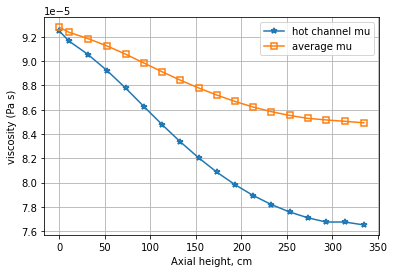

In [66]:
import matplotlib.pyplot as plt
plt.plot(zMap, muMax , marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'hot channel mu')
plt.plot(zMap, muAvg , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'average mu')
plt.xlabel('Axial height, cm')
plt.ylabel('viscosity (Pa s)')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_mu")

### Pressure drop data

In [67]:
### pressure drop data
for channelId in range(31):
    dPtot,dPaccl,dPgrav,dPfric,dPform = core.get('axial',(channelId,slice(None)),['dPtot','dPaccl','dPgrav','dPfric','dPform'],'array')
    if channelId == 0:
        dPtots  = dPtot
        dPaccls = dPaccl
        dPgravs = dPgrav
        dPfrics = dPfric
        dPforms = dPform
    else:
        dPtots  = np.vstack((dPtots ,dPtot))
        dPaccls = np.vstack((dPaccls,dPaccl))
        dPgravs = np.vstack((dPgravs,dPgrav))
        dPfrics = np.vstack((dPfrics,dPfric))
        dPforms = np.vstack((dPforms,dPform))

In [68]:
#dPtot  = dPtots[channelMax]
#dPaccl = dPaccls[channelMax]
#dPgrav = dPgravs[channelMax]
#dPfric = dPfrics[channelMax]
#dPform = dPforms[channelMax]

dPtot  = np.sum(dPtots*wts,axis=0)/np.sum(wts)/1000
dPaccl = np.sum(dPaccls*wts,axis=0)/np.sum(wts)/1000
dPgrav = np.sum(dPgravs*wts,axis=0)/np.sum(wts)/1000
dPfric = np.sum(dPfrics*wts,axis=0)/np.sum(wts)/1000
dPform = np.sum(dPforms*wts,axis=0)/np.sum(wts)/1000

In [69]:
# supress zero form losses
ndx = np.where(dPform==0)[0]
dPform[ndx] = np.nan

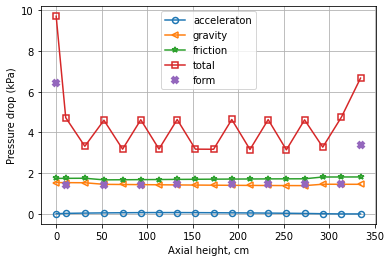

In [70]:
import matplotlib.pyplot as plt
plt.plot(zMap, dPaccl, marker = 'o', fillstyle='none',markeredgewidth=1.5, label = 'acceleraton')
plt.plot(zMap, dPgrav, marker = '<', fillstyle='none',markeredgewidth=1.5, label = 'gravity')
plt.plot(zMap, dPfric, marker = '*', fillstyle='none',markeredgewidth=1.5, label = 'friction')
plt.plot(zMap, dPtot , marker = 's', fillstyle='none',markeredgewidth=1.5, label = 'total')
plt.plot(zMap, dPform, marker = 'x', fillstyle='none',markeredgewidth=4.0, label = 'form', linestyle='None')
plt.xlabel('Axial height, cm')
plt.ylabel('Pressure drop (kPa)')
plt.grid(), plt.legend()
plt.savefig("./figures/ax_dP")

## Channel data

In order to depict a geometric representation of the data, a channel map must be defined. -1s indicate no channel is at a certain location. 

In [71]:
channelMap = np.array([
                    [-1, -1, -1, -1, 30, 29, 28, 27, 28, 29, 30, -1, -1, -1, -1],
                    [-1, -1, 26, 25, 24, 23, 22, 21, 22, 23, 24, 25, 26, -1, -1],
                    [-1, 26, 20, 19, 18, 17, 16, 15, 16, 17, 18, 19, 20, 26, -1],
                    [-1, 25, 19, 14, 13, 12, 11, 10, 11, 12, 13, 14, 19, 25, -1],
                    [30, 24, 18, 13,  9,  8,  7,  6,  7,  8,  9, 13, 18, 24, 30],
                    [29, 23, 17, 12,  8,  5,  4,  3,  4,  5,  8, 12, 17, 23, 29],
                    [28, 22, 16, 11,  7,  4,  2,  1,  2,  4,  7, 11, 16, 22, 28],
                    [27, 21, 15, 10,  6,  3,  1,  0,  1,  3,  6, 10, 15, 21, 27],
                    [28, 22, 16, 11,  7,  4,  2,  1,  2,  4,  7, 11, 16, 22, 28],
                    [29, 23, 17, 12,  8,  5,  4,  3,  4,  5,  8, 12, 17, 23, 29],
                    [30, 24, 18, 13,  9,  8,  7,  6,  7,  8,  9, 13, 18, 24, 30],
                    [-1, 25, 19, 14, 13, 12, 11, 10, 11, 12, 13, 14, 19, 25, -1],
                    [-1, 26, 20, 19, 18, 17, 16, 15, 16, 17, 18, 19, 20, 26, -1],
                    [-1, -1, 26, 25, 24, 23, 22, 21, 22, 23, 24, 25, 26, -1, -1],
                    [-1, -1, -1, -1, 30, 29, 28, 27, 28, 29, 30, -1, -1, -1, -1]
                    ])

### Power by channel

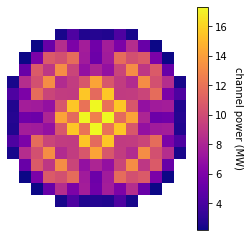

In [72]:
powerTot = np.sum(power,axis=1)/1e6

npaths.channelPlot(powerTot,channelMap,"channel power (MW)",save="./figures/chan_power")

### Maximum fuel temperatures by channel

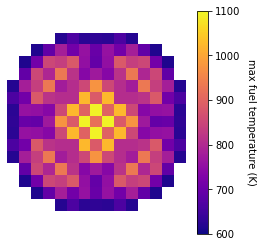

In [73]:
maxTemp = np.zeros(31)
for channelId in range(31):
    axialTemps = core.get('fuel',(channelId,slice(None),22),['tIn'],'array')
    maxTemp[channelId] = axialTemps.max()

npaths.channelPlot(maxTemp,channelMap,"max fuel temperature (K)",600,1100,save="./figures/chan_maxTemp")

### Mass flow rate by channel

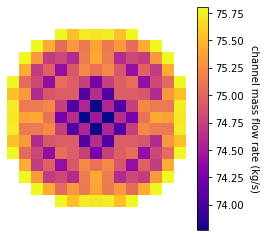

In [74]:
mDot = core.get('channel',(slice(None)),['mDot'],'array')

npaths.channelPlot(mDot,channelMap,"channel mass flow rate (kg/s)",save="./figures/chan_mDot")

### Pressure drop by channel

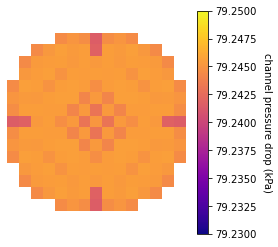

In [76]:
pIn  = core.get('multiChannel',(slice(None)),['pIn'],'array')
pOut = core.get('channel',(slice(None)),['pOut'],'array')
dPtot = (pOut-pIn)*-1e-3

npaths.channelPlot(dPtot,channelMap,"channel pressure drop (kPa)",79.23,79.25,save="./figures/chan_dP")